In [2]:
# import relevant libraries
from src import common

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats

import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

# Analsys of Exchange Rate Time Series

In [10]:
# load Exchange Rate for Israel

ex_rate = pd.read_csv('exchange_rate_ISR.csv', names=['date','amount'], header=0)
print(ex_rate.dtypes)
print(ex_rate.head())

# change dates to datetime index
ex_rate['date'] = pd.to_datetime(ex_rate['date'], format='%Y-%m-%d')
ex_rate.set_index('date', inplace=True)
print("------------------ Exchange rates for Israel (USD/ILS) ----------------------")
print(ex_rate)
print("---------------------------------------------------------")

date       object
amount    float64
dtype: object
         date    amount
0  2001-01-01  4.115913
1  2001-02-01  4.122250
2  2001-03-01  4.158727
3  2001-04-01  4.175143
4  2001-05-01  4.139522
------------------ Exchange rates for Israel (USD/ILS) ----------------------
              amount
date                
2001-01-01  4.115913
2001-02-01  4.122250
2001-03-01  4.158727
2001-04-01  4.175143
2001-05-01  4.139522
...              ...
2022-11-01  3.481864
2022-12-01  3.453455
2023-01-01  3.448636
2023-02-01  3.543150
2023-03-01  3.617261

[267 rows x 1 columns]
---------------------------------------------------------


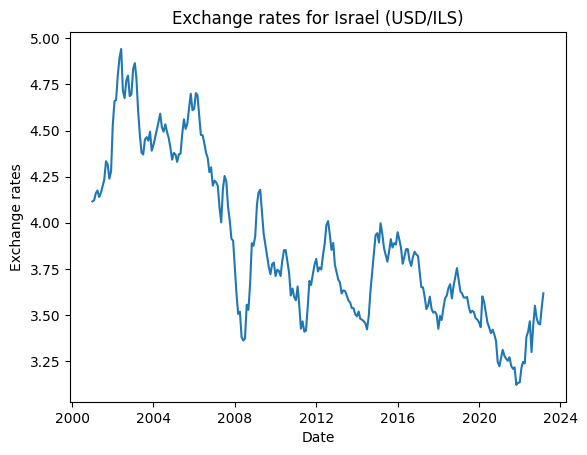

In [5]:
# plotting the series
plt.plot(ex_rate.amount)
plt.title('Exchange rates for Israel (USD/ILS)')
plt.ylabel('Exchange rates')
plt.xlabel('Date')
plt.show()

In [26]:
# Preparing the data to check different transformations
y1 = ex_rate.amount
dy1 = y1.diff().dropna()
ddy1 = y1.diff().dropna().diff().dropna()
ly1 = np.log(y1)
dly1 = np.log(y1).diff().dropna()
ddly1 = np.log(y1).diff().dropna().diff().dropna()

#### Comments:
While looking at the Exchage Rates time series, one may notice that the plot does not exhibit a pattern where the amplitude of the seasonal or trend components varies proportionally with the level of the data, thus additive model for decomposition will be performed.

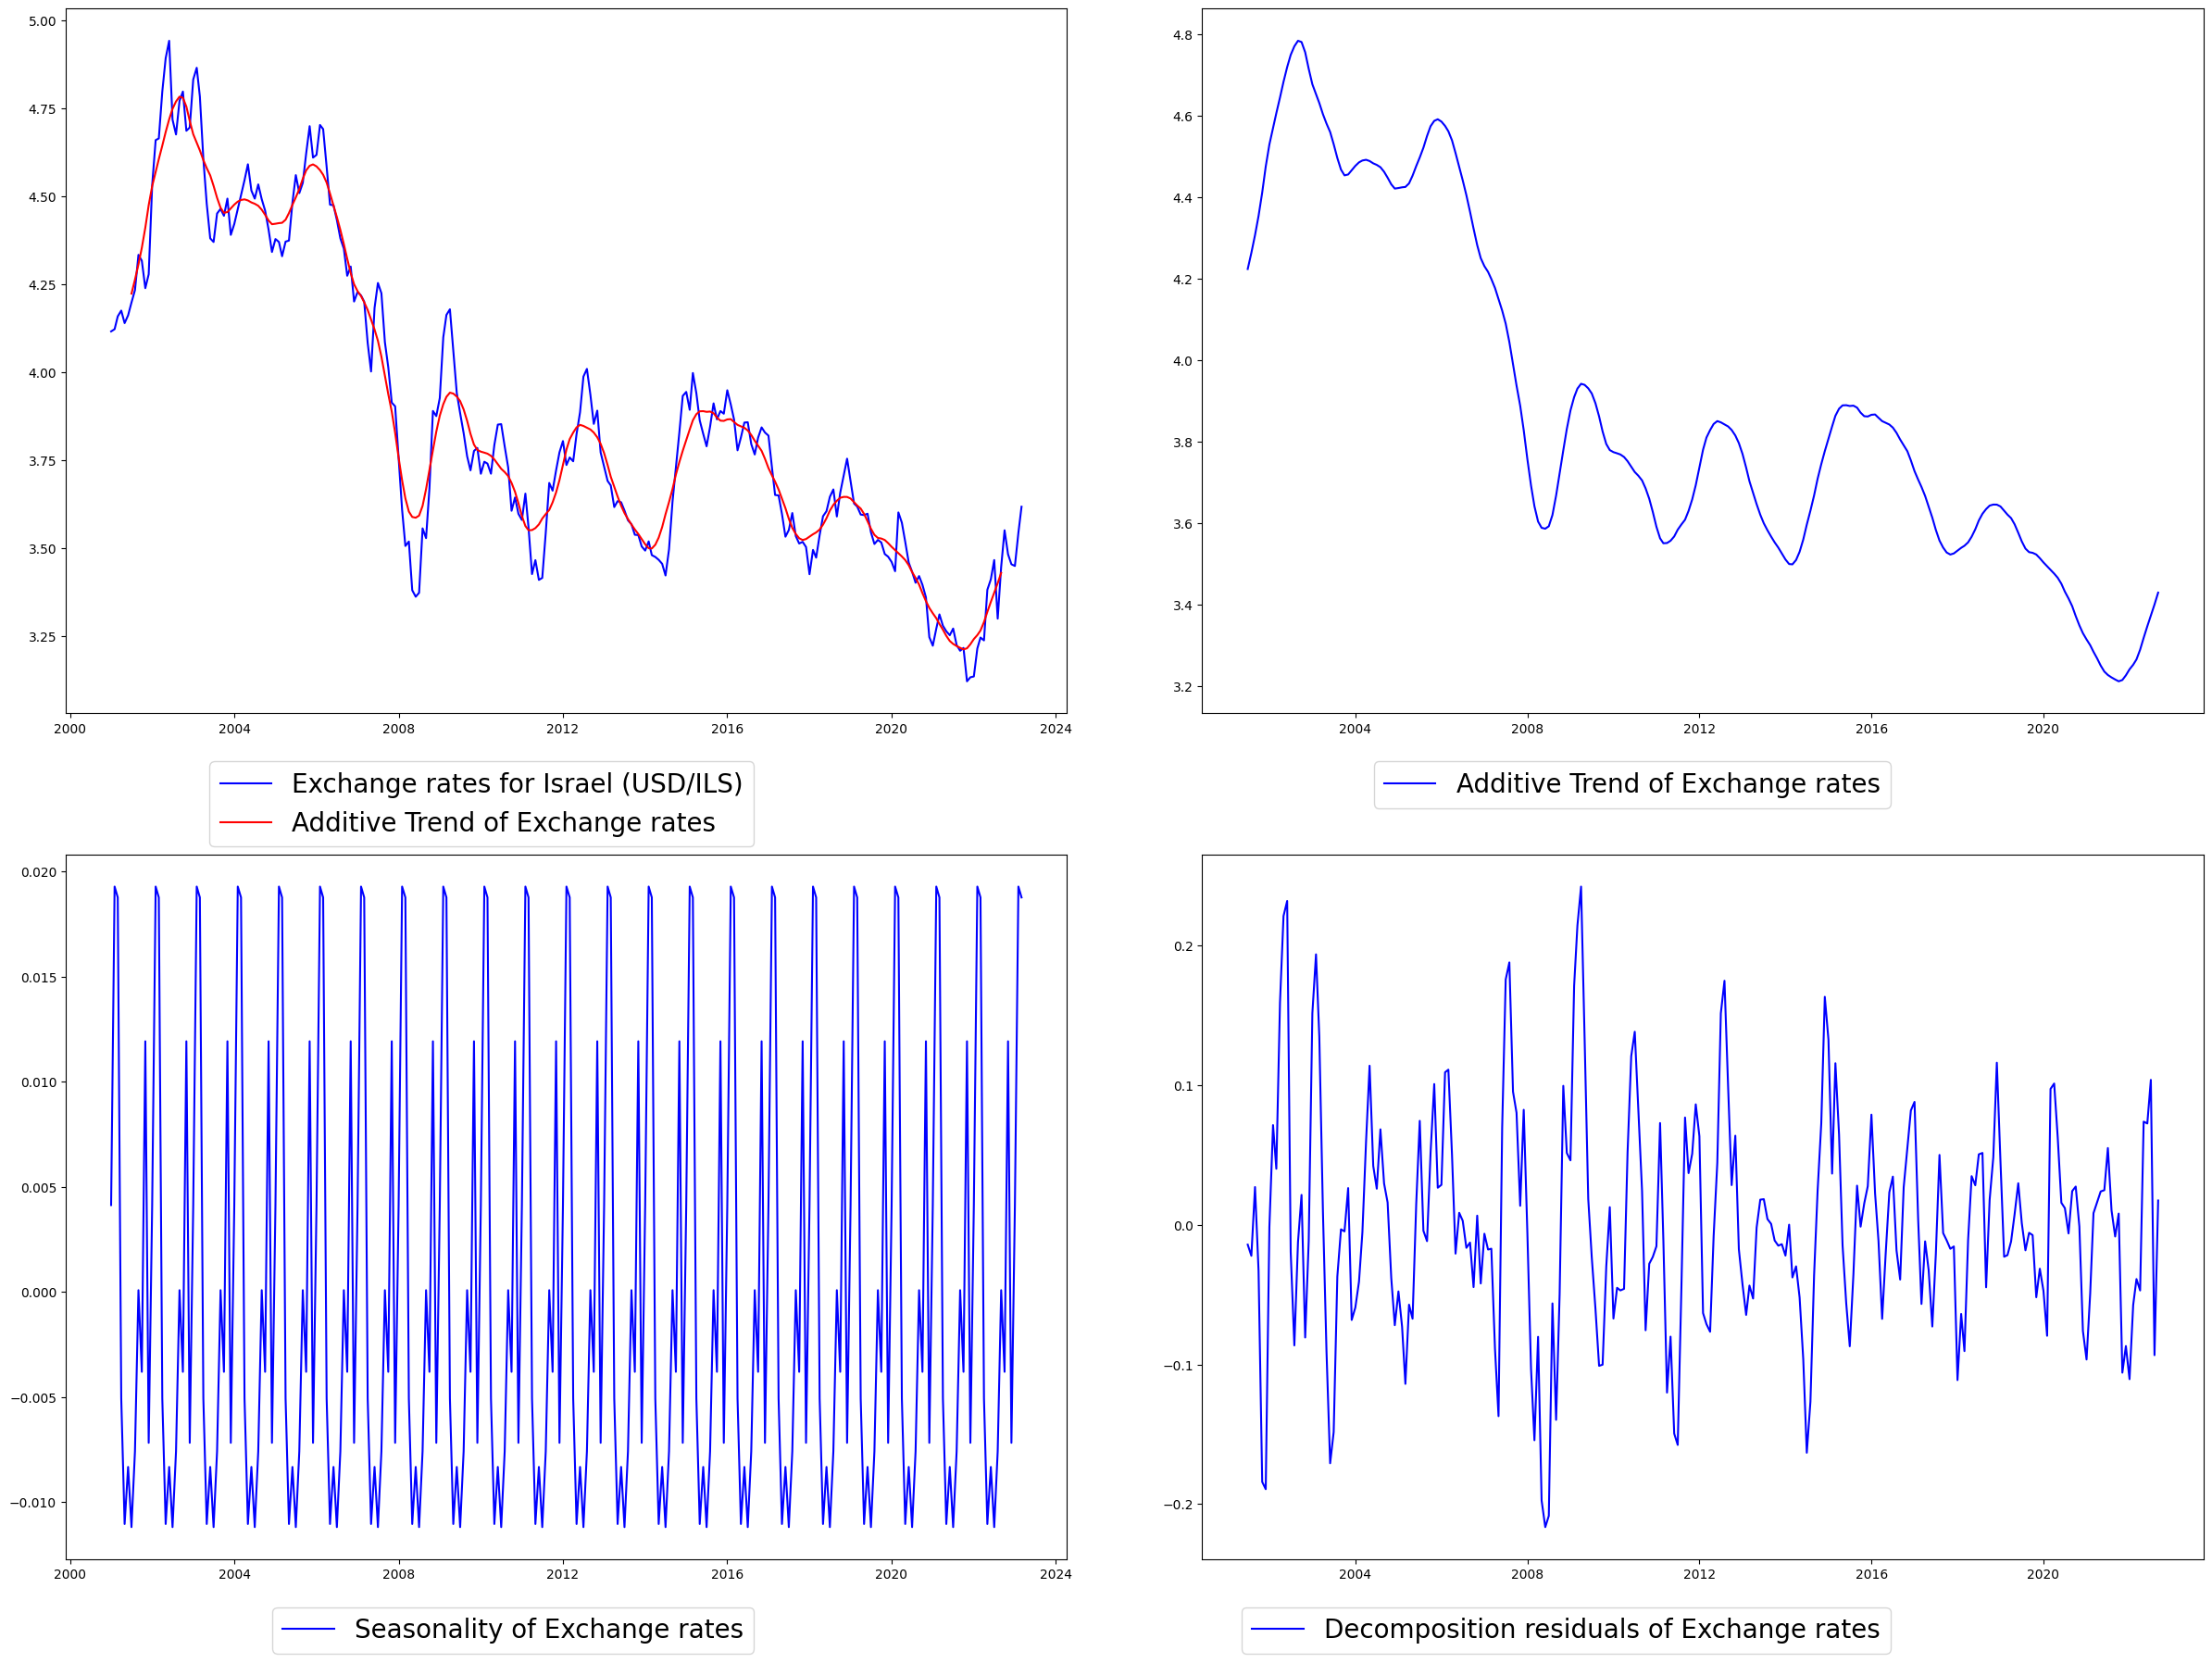

In [12]:
# decompose the series - additive model
additive1 = seasonal_decompose(y1, model='additive')
trend_estimate1 = additive.trend
periodic_estimate1 = additive.seasonal
residual1 = additive.resid

plt.rcParams["figure.figsize"] = (24,18)
plt.subplot(221)
plt.plot(ex_rate.amount ,label='Exchange rates for Israel (USD/ILS)', color='blue')
plt.plot(trend_estimate1 ,label='Additive Trend of Exchange rates' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(trend_estimate1,label='Additive Trend of Exchange rates',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(periodic_estimate1,label='Seasonality of Exchange rates',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(residual1,label='Decomposition residuals of Exchange rates',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

#### Comments:
When we looked at the time series and broke it down into different parts using a method called additive model, we found that the remaining part after decomposition could already be considered stationary. However, the seasonal part of the data showed very little variation - between -0.01 and 0.02 (0.3 range, which is less than 2% of the range of time series), making it difficult to say for sure if there was a clear seasonal pattern in the original data. Additionaly, the trend resembles a stochastic trend more than a deterministic trend. So, using the additive model might not be the best way to make the data stationary, and it could be more effective to take the difference between consecutive data points.

In [13]:
additive_components1 = pd.DataFrame([additive1.observed, additive1.trend,
                                    additive1.seasonal, additive1.resid]).T
additive_components1.columns = ["observed", "trend", "seasonal", "resid"]
additive_components1['sum'] = additive_components1.sum(numeric_only=True, axis=1)
additive_components1['product'] = additive_components1.loc[:,"trend":"resid"].product(axis=1, numeric_only=True)

In [17]:
# check stationarity for residuals
y_add_resid1 = additive_components1.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res1 = tsa.adfuller(y_add_resid1, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res1[1])
res1 = tsa.adfuller(y_add_resid1, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res1[1])
res1 = tsa.adfuller(y_add_resid1, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res1 = tsa.adfuller(y_add_resid1, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res1[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 1.7065851056861904e-10
    (2) ADF p-value (const + trend): 3.0804665263111437e-09
    (3) ADF p-value (const + trend + quad trend): 1.4712566069987537e-11
    (4) ADF p-value (no const + no trend): 1.4712566069987537e-11


#### Comments:
The p-values from the Dickey-Fuller test, which are close to 0 for all underlying models, indicate that removing the trend and seasonality has made the remaining residuals stationary. However, the additive decomposition method has limitations. It assumes fixed seasonal periods, constant seasonal components, and linear trends. Observing the Exchange Rates time series, one can notice that these limitations might be present in the series. Therefore, the STL decomposition method will be performed to address these concerns.

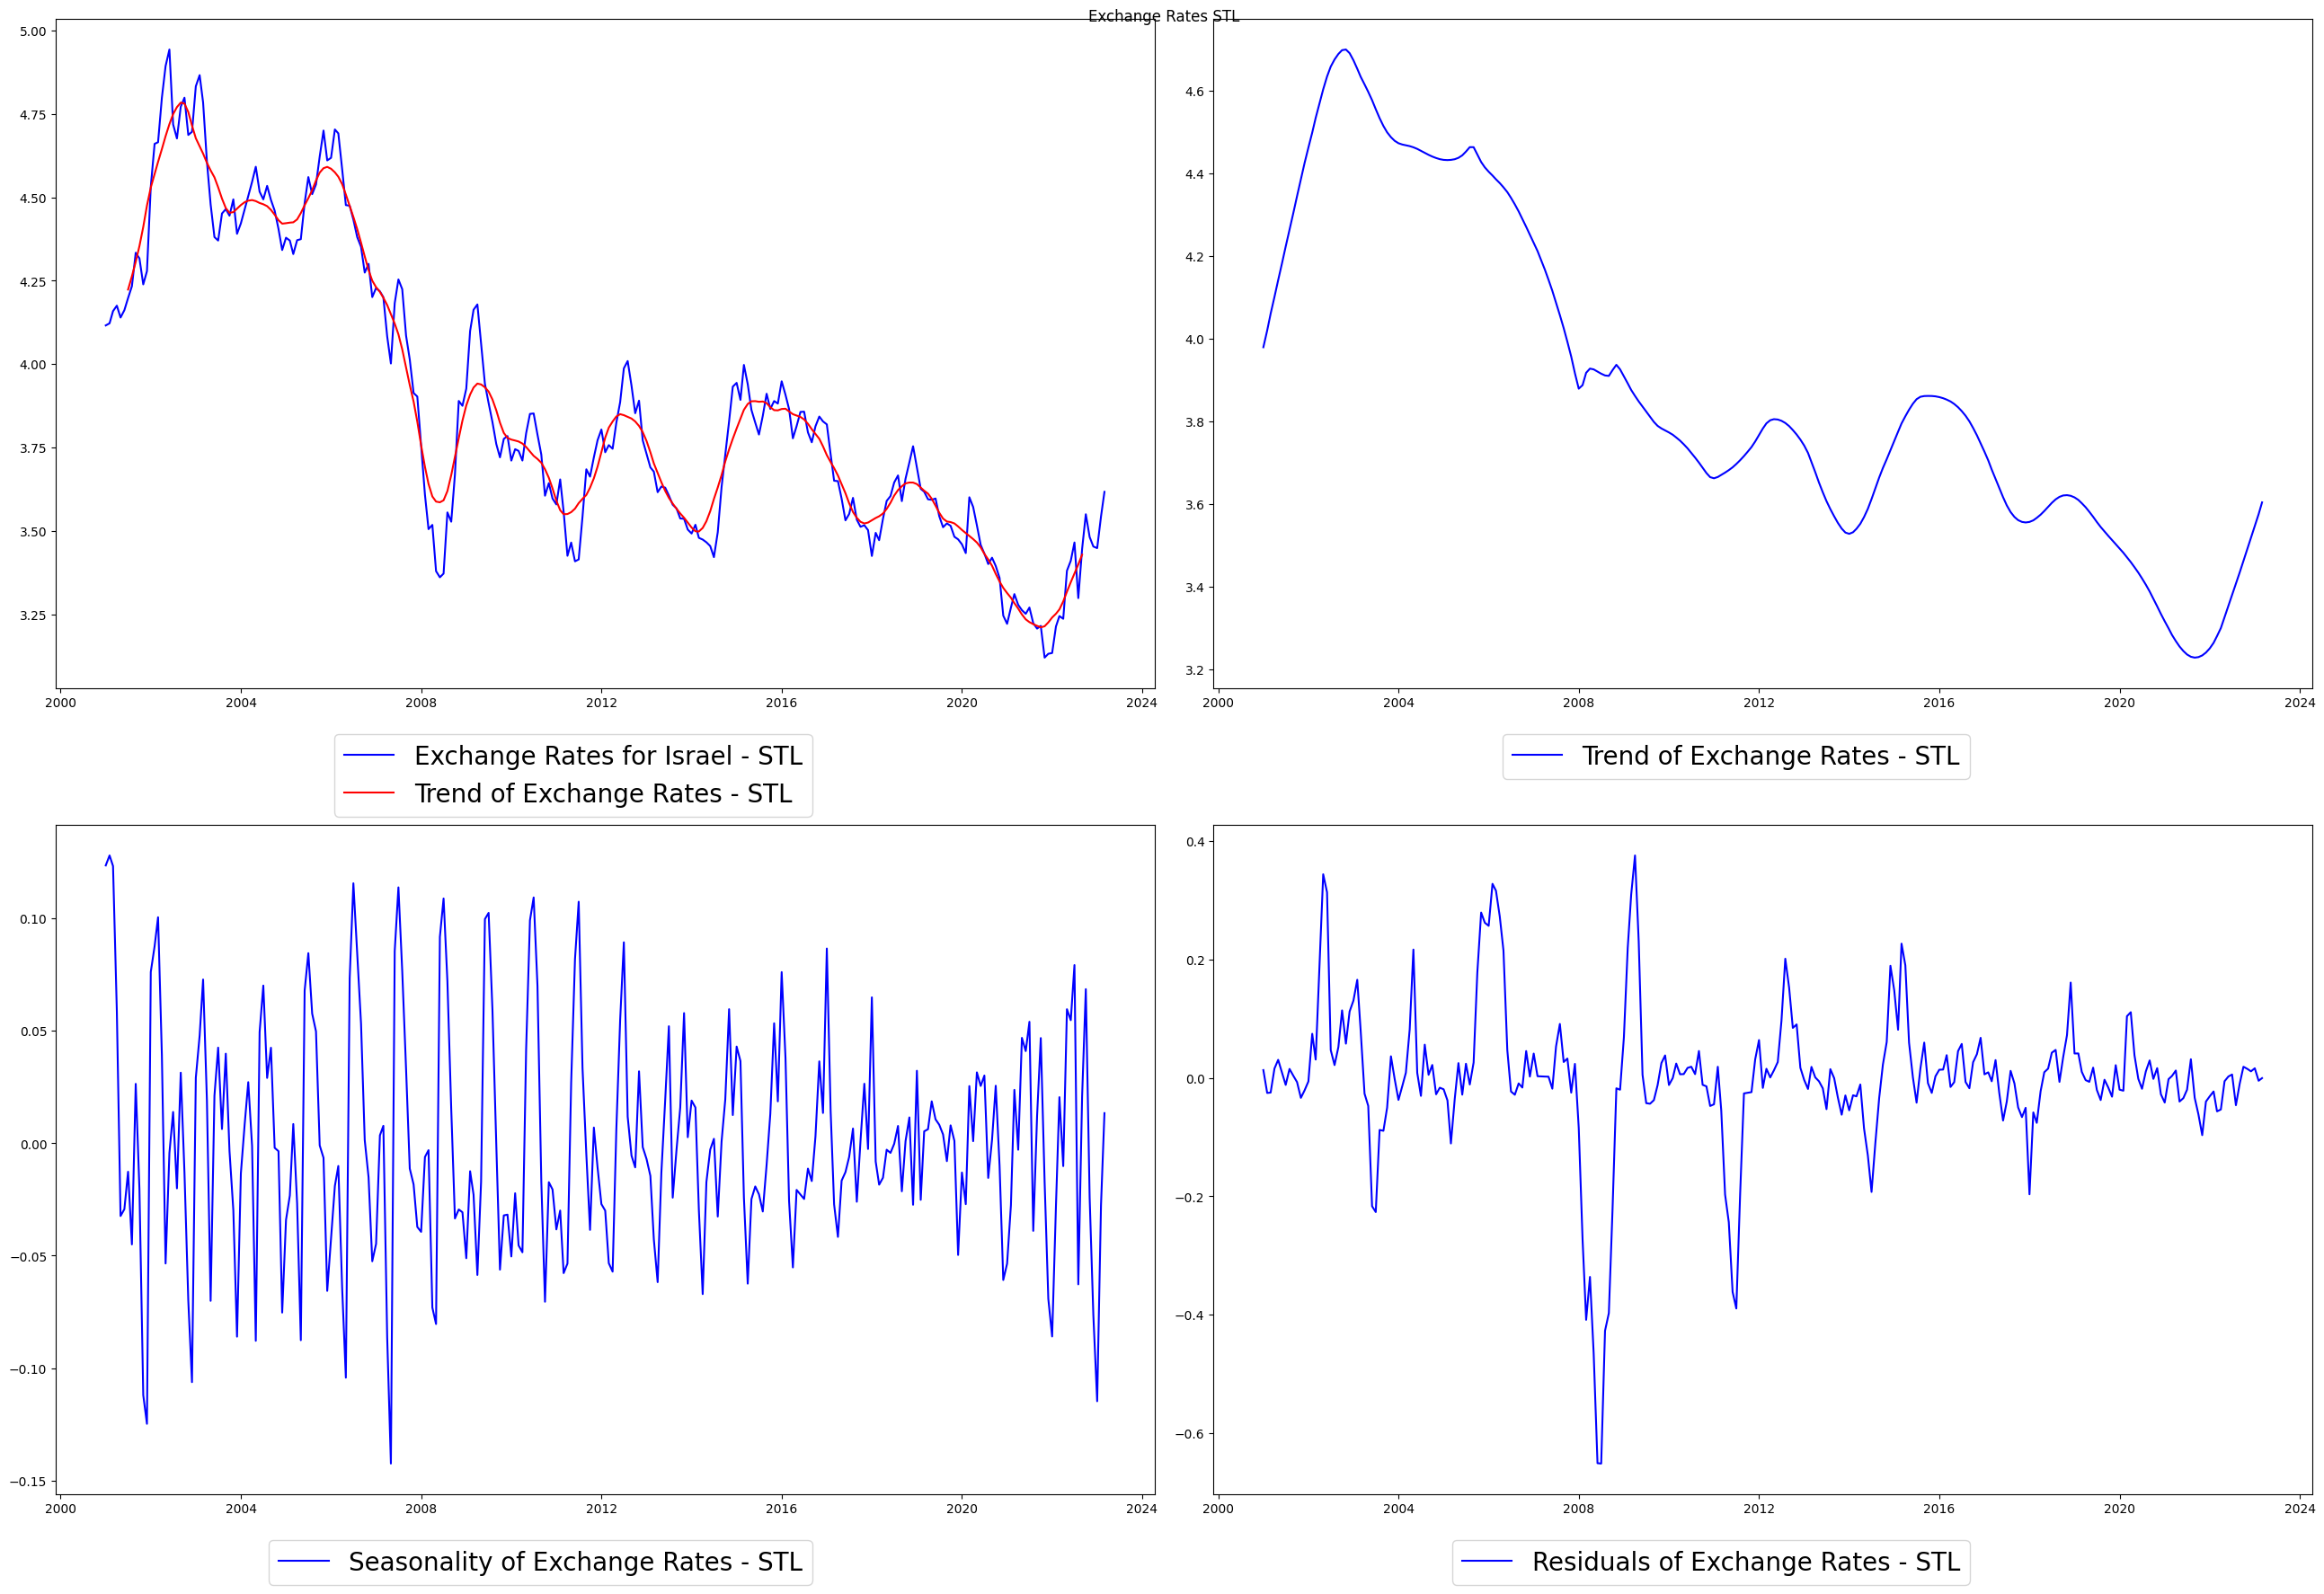

In [15]:
# decompose with STL
ex_rate_stl = STL(y1, robust=True).fit()

plt.rcParams["figure.figsize"] = (26,18)
plt.suptitle('Exchange Rates STL', )
plt.subplot(221)
plt.plot(ex_rate_stl.observed ,label='Exchange Rates for Israel - STL', color='blue')
plt.plot(trend_estimate ,label='Trend of Exchange Rates - STL' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(ex_rate_stl.trend ,label='Trend of Exchange Rates - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(ex_rate_stl.seasonal ,label='Seasonality of Exchange Rates - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(ex_rate_stl.resid ,label='Residuals of Exchange Rates - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()


#### Comments:
Looking at the seasonality plot, one can see that STL decomposition allows for different patterns of seasonality to be shown- these patterns can change variability along the x-axis. However, this variability of the seasonality is still very low (range of 0.05). The trend plot obtained from STL decomposition does not differ much from the one obtained from additive decomposition. The residuals seem to be stationary at first glance, so to confirm it, the formal test for stationarity of residuals will be performed.

In [16]:
# check stationarity for residuals
y_resid1 = ex_rate_stl.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res1 = tsa.adfuller(y_resid1, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res1[1])
res1 = tsa.adfuller(y_resid1, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res1[1])
res1 = tsa.adfuller(y_resid1, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res1[1])
res1 = tsa.adfuller(y_resid1, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res1[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 1.6281451479589008e-07
    (2) ADF p-value (const + trend): 1.950138942192589e-06
    (3) ADF p-value (const + trend + quad trend): 7.470485425155095e-06
    (4) ADF p-value (no const + no trend): 8.689498106481279e-09


#### Comments:
The formal tests confirms that for all underlying models the residuals are now stationary at all levels of significance. The plots for residuals are shown below for visual investigation.

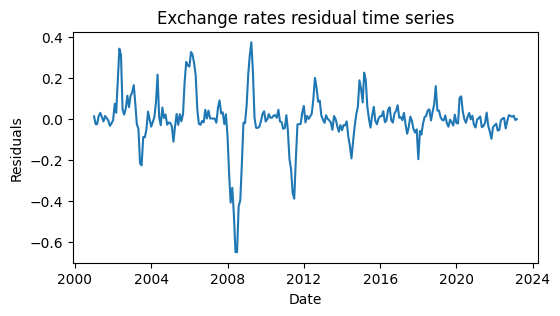

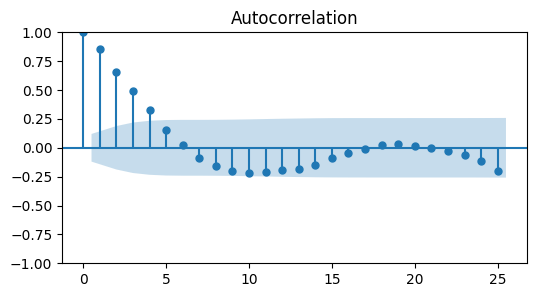

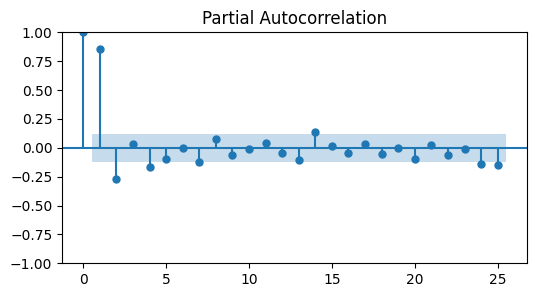

In [20]:
# Exchange rates residuals time series, acf and pacf

plt.figure()
plt.plot(y_resid1 )
plt.title('Exchange rates residuals time series')
plt.ylabel('Residuals')
plt.xlabel('Date')
plt.show()

# plot acf for level
plot_acf(y_resid1 )
plt.show()

# plot pacf for level
plot_pacf(y_resid1 , method='ywm')
plt.show()

#### Comments:
Even though, the residual series looks stationary, which is also confirmed by the underlying tests, still there can be small issue detected. The autocorrelation has a clear pattrn which indicates some residuals seasonality and might influence the reliability and accuracy of the model. Thus, other approaches of making data stationary are considered below: the deseasoning and first order difference; just order difference.

First order differenced series


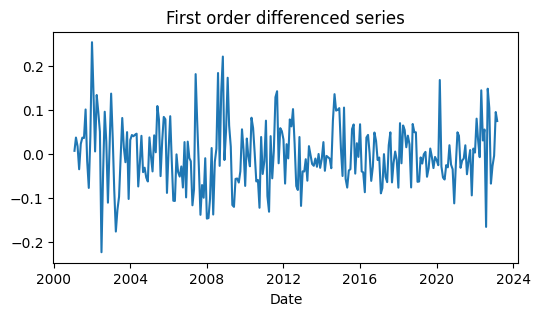

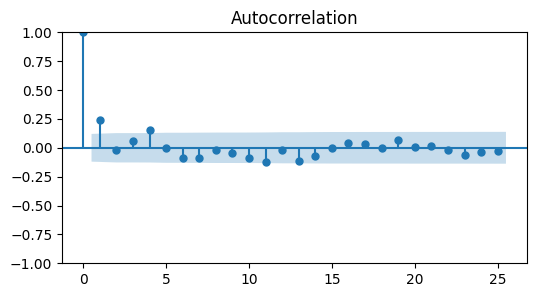

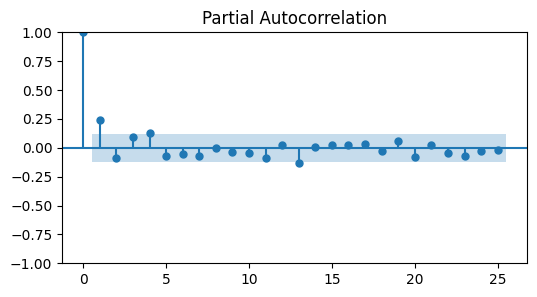

ADF test - various underlying models:
   (1) ADF p-value (const): 1.6312233928958386e-23
   (2) ADF p-value (const + trend): 4.8762768594950534e-20
   (3) ADF p-value (const + trend + quad trend): 1.1511907724672697e-20
   (4) ADF p-value (no const + no trend): 4.802962858391712e-23
-------------------------------------------------


In [28]:
# (5) First order differenced

print("First order differenced series")

plt.plot(dy1)
plt.title('First order differenced series')
plt.xlabel('Date')
plt.show()

# plot acf and pacf
plot_acf(dy1)
plt.show()
plot_pacf(dy1,method='ywm')
plt.show()

print("ADF test - various underlying models:")
res = tsa.adfuller(dy1, regression='c',autolag='AIC')
print("   (1) ADF p-value (const):",res[1])
res = tsa.adfuller(dy1, regression='ct',autolag='AIC')
print("   (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(dy1, regression='ctt',autolag='AIC')
print("   (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(dy1, regression='n',autolag='AIC')
print("   (4) ADF p-value (no const + no trend):",res[1])
print("-------------------------------------------------")

De-seasoned series


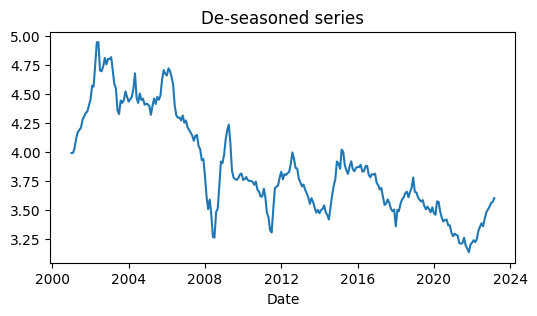

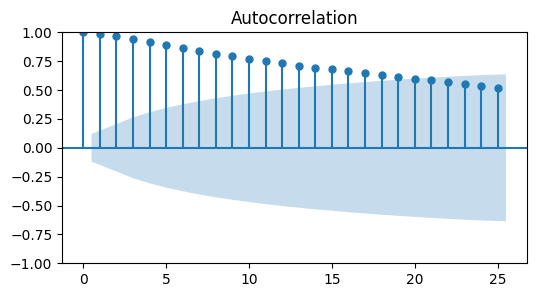

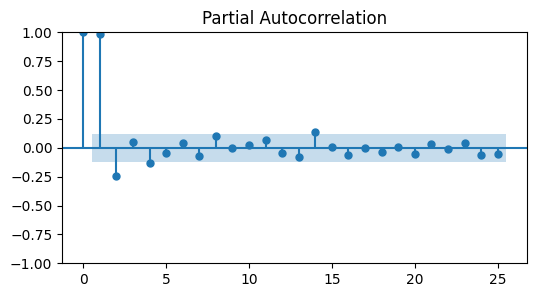

ADF test - various underlying models:
   (1) ADF p-value (const): 0.36933966634051396
   (2) ADF p-value (const + trend): 0.042135299090290707
   (3) ADF p-value (const + trend + quad trend): 0.027914906440875215
   (4) ADF p-value (no const + no trend): 0.2675235960876456
-------------------------------------------------


In [30]:
# De-seasoned

print("De-seasoned series")
y2 = y1 - ex_rate_stl.seasonal

plt.plot(y2)
plt.title('De-seasoned series')
plt.xlabel('Date')
plt.show()

# plot acf and pacf
plot_acf(y2)
plt.show()
plot_pacf(y2,method='ywm')
plt.show()

print("ADF test - various underlying models:")
res = tsa.adfuller(y2, regression='c',autolag='AIC')
print("   (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y2, regression='ct',autolag='AIC')
print("   (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y2, regression='ctt',autolag='AIC')
print("   (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y2, regression='n',autolag='AIC')
print("   (4) ADF p-value (no const + no trend):",res[1])
print("-------------------------------------------------")

#### Comments:
The 1st and 4th underlaying models clearly shows that the data is not stationary yet. The 2nd and 3rd models indicate, that the data might be stationary just on significance level of 0.01. Additionally the visual inspection shows that the data is not stationary- there is some trend in the de-seasoned exchange rate series, thus further manipulation is necessary to make data stationary. 

De-seasoned and first order differenced series


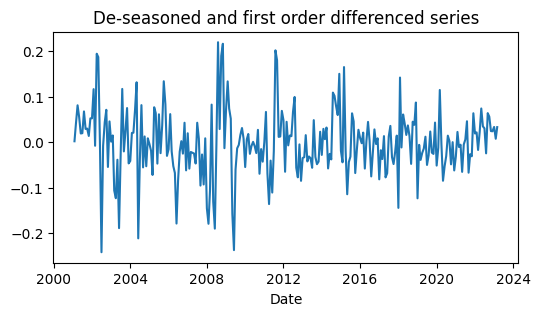

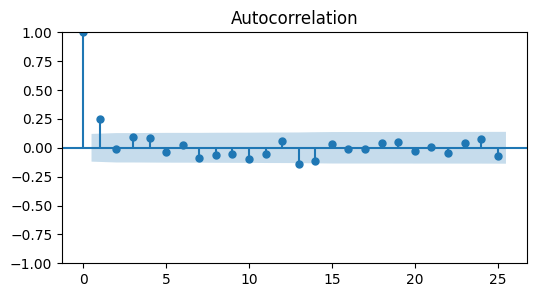

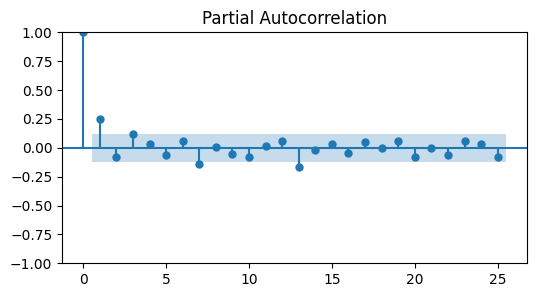

ADF test - various underlying models:
   (1) ADF p-value (const): 1.0114433731692805e-06
   (2) ADF p-value (const + trend): 1.3746638075786642e-05
   (3) ADF p-value (const + trend + quad trend): 6.654562810111988e-05
   (4) ADF p-value (no const + no trend): 7.188621775045254e-08
-------------------------------------------------


In [31]:
# De-season and first order differenced
print("De-seasoned and first order differenced series")
y2 = y1 - ex_rate_stl.seasonal
y2 = y2.diff().dropna()

plt.plot(y2)
plt.title('De-seasoned and first order differenced series')
plt.xlabel('Date')
plt.show()

# plot acf and pacf
plot_acf(y2)
plt.show()
plot_pacf(y2,method='ywm')
plt.show()

print("ADF test - various underlying models:")
res1 = tsa.adfuller(y2, regression='c',autolag='AIC')
print("   (1) ADF p-value (const):",res1[1])
res1 = tsa.adfuller(y2, regression='ct',autolag='AIC')
print("   (2) ADF p-value (const + trend):",res1[1])
res1 = tsa.adfuller(y2, regression='ctt',autolag='AIC')
print("   (3) ADF p-value (const + trend + quad trend):",res1[1])
res1 = tsa.adfuller(y2, regression='n',autolag='AIC')
print("   (4) ADF p-value (no const + no trend):",res1[1])
print("-------------------------------------------------")

#### Comment:
Both methods of making data stationary: deseasoning and 1st order difference, and just 1st order difference give very similar results- all underlying models have p- values close to 0. Since it seems like de-seasoning removed some part of non-stationarity of the data and it is generally good practice to remove the regurality from the data, further analysis on creating ARMA models, will be conducded on de-seasoned data on 1st difference order. 

# Analysis of CPI Time Series

In [6]:
# load Consumer Price Index for Israel

cpi = pd.read_csv('ISRCPIALLQINMEI.csv', names=['date','amount'], header=0)
print(cpi.dtypes)
print(cpi.head())

# change dates to datetime index
cpi['date'] = pd.to_datetime(cpi['date'], format='%Y-%m-%d')
cpi.set_index('date', inplace=True)
print("------------------ CPI for Israel ----------------------")
print(cpi)
print("---------------------------------------------------------")

date       object
amount    float64
dtype: object
         date     amount
0  2001-01-01  75.436828
1  2001-04-01  76.478495
2  2001-07-01  77.318548
3  2001-10-01  77.217742
4  2002-01-01  78.393817
------------------ CPI for Israel ----------------------
                amount
date                  
2001-01-01   75.436828
2001-04-01   76.478495
2001-07-01   77.318548
2001-10-01   77.217742
2002-01-01   78.393817
...                ...
2021-10-01  103.259409
2022-01-01  104.301075
2022-04-01  106.283602
2022-07-01  107.829301
2022-10-01  108.635753

[88 rows x 1 columns]
---------------------------------------------------------


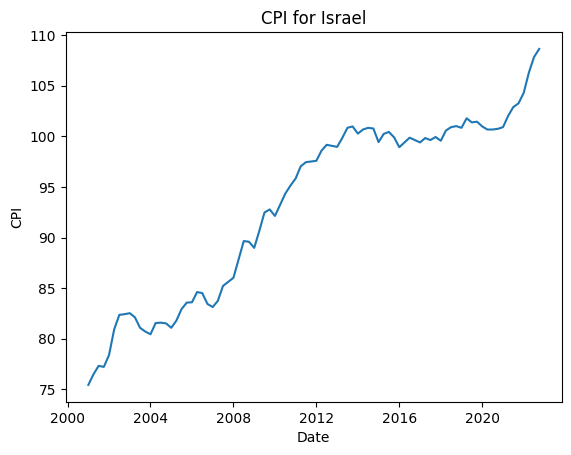

In [7]:
# plotting the series
plt.plot(cpi.amount)
plt.title('CPI for Israel')
plt.ylabel('CPI')
plt.xlabel('Date')
plt.show()

In [8]:
# Preparing the data to check different transformations
y = cpi.amount
dy = y.diff().dropna()
ddy = y.diff().dropna().diff().dropna()
ly = np.log(y)
dly = np.log(y).diff().dropna()
ddly = np.log(y).diff().dropna().diff().dropna()

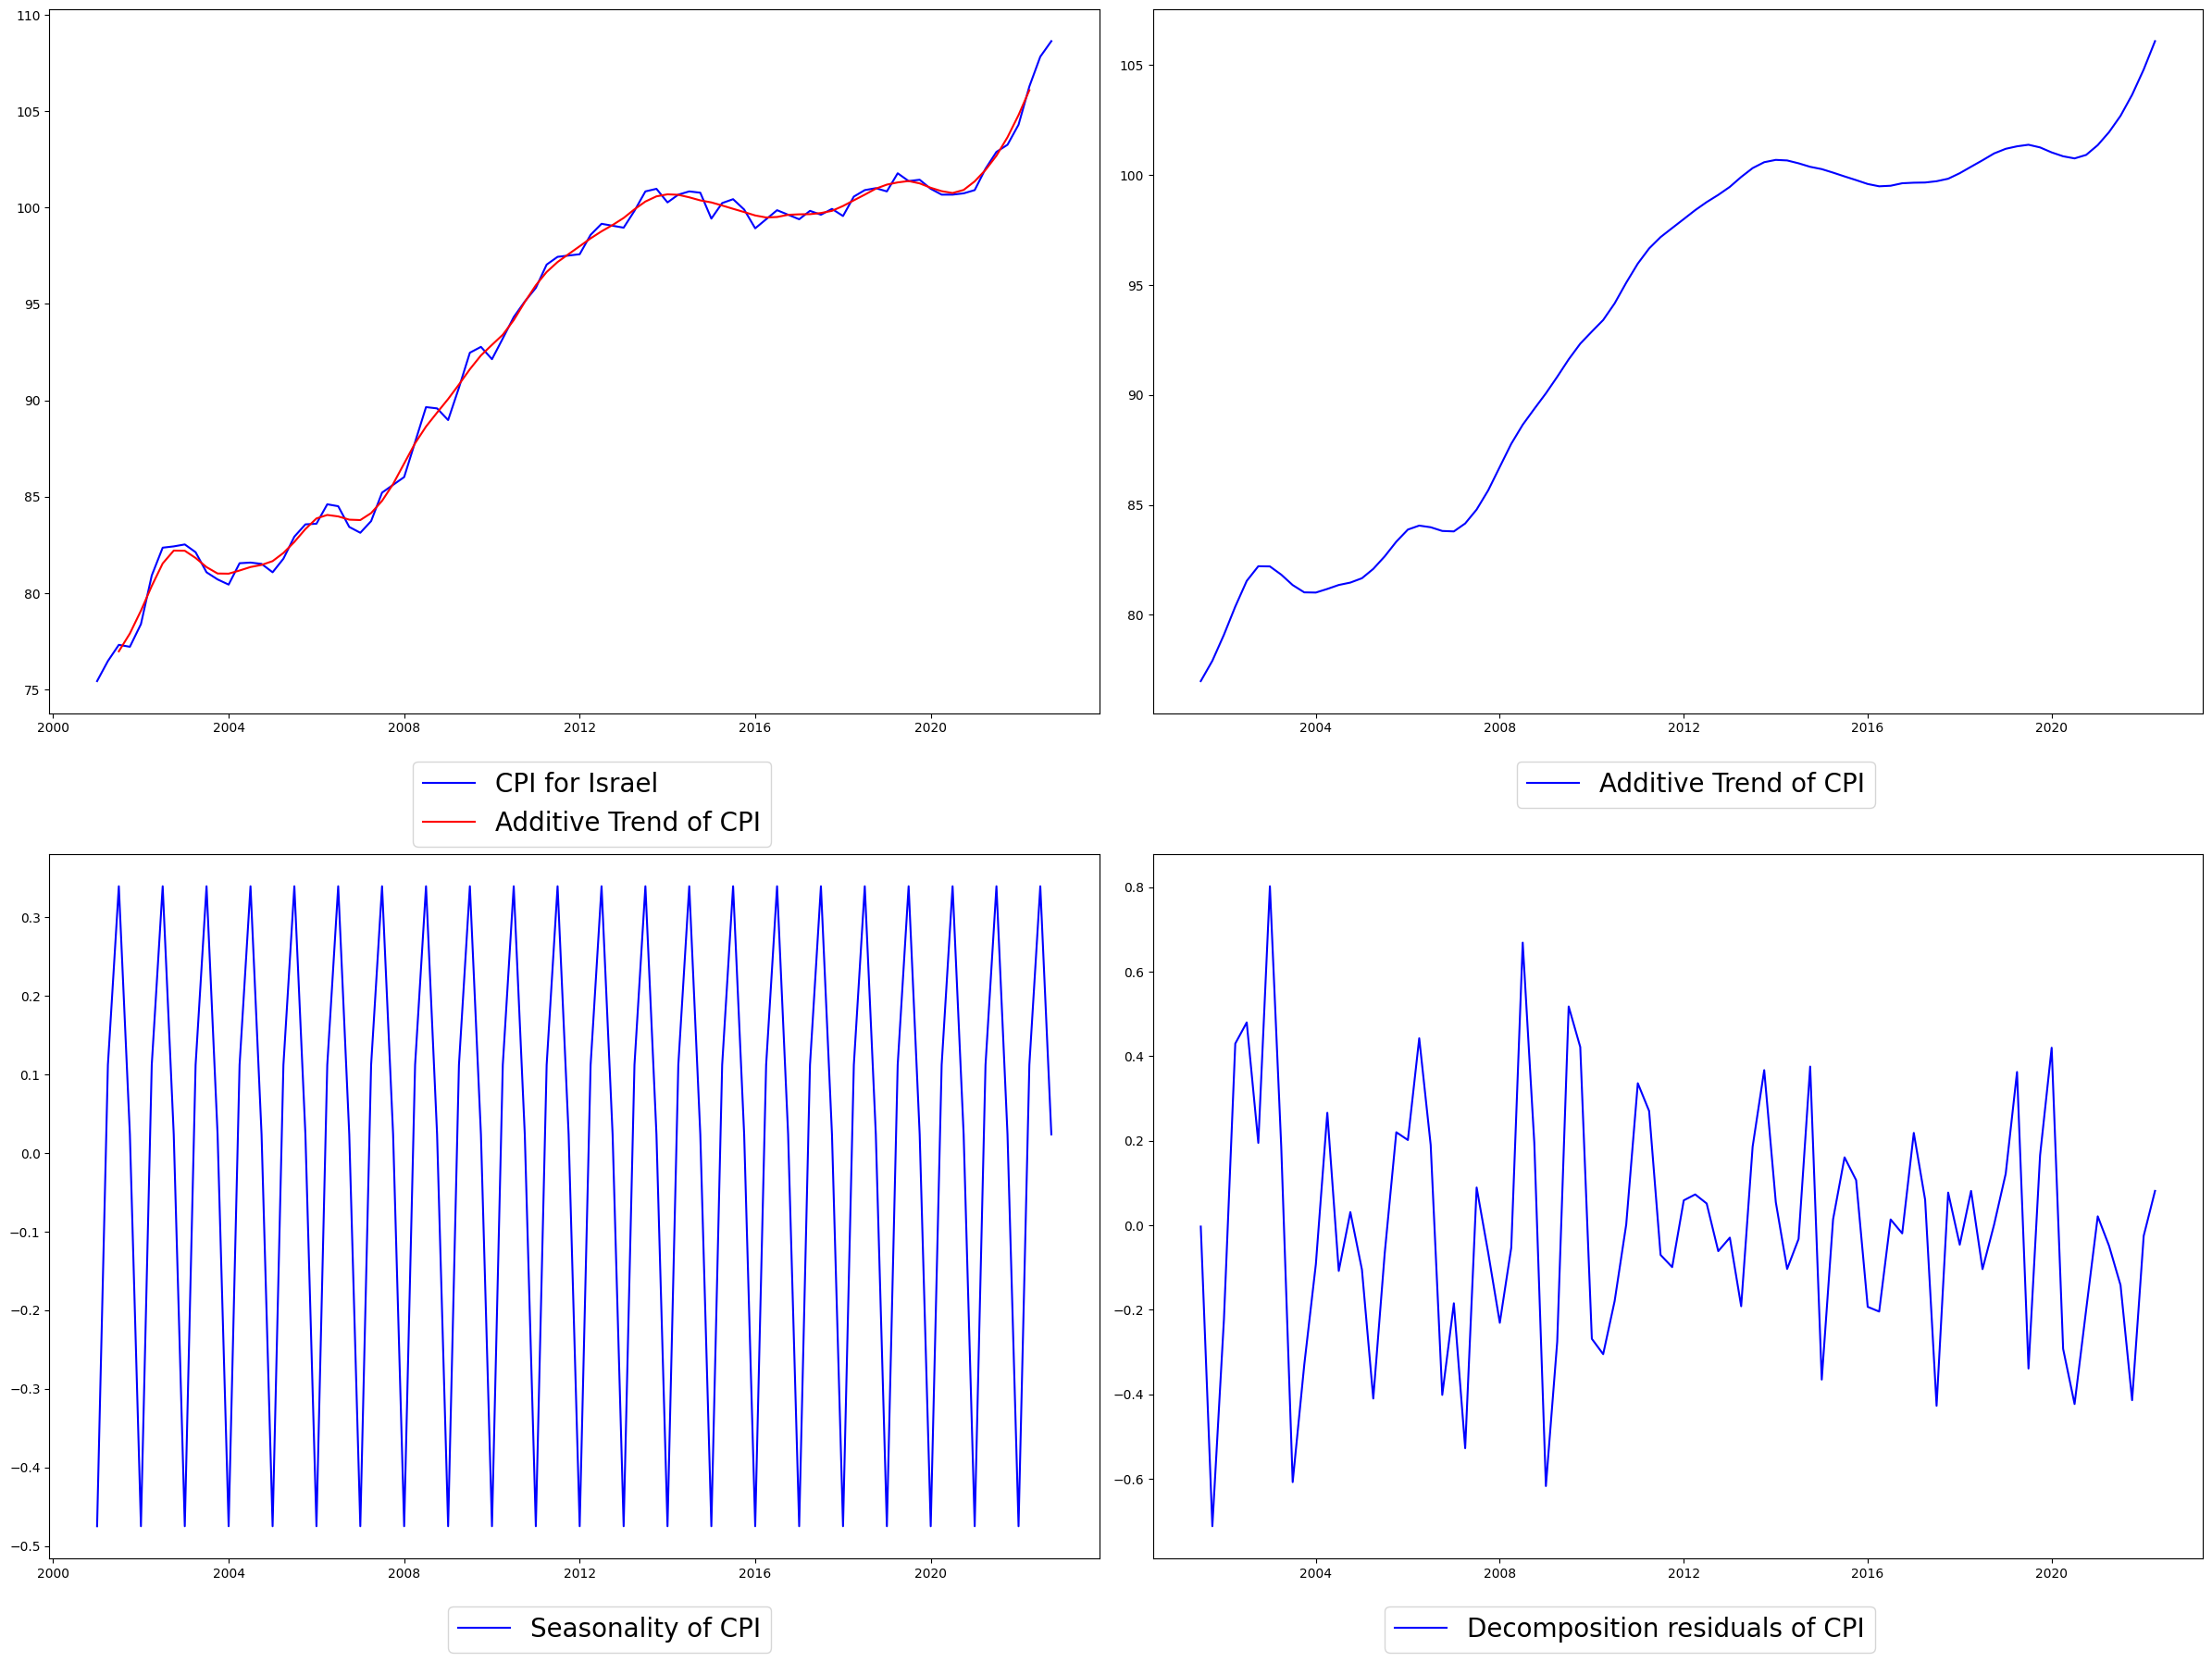

In [9]:
# decompose the series - additive model
additive = seasonal_decompose(y, model='additive')
trend_estimate = additive.trend
periodic_estimate = additive.seasonal
residual = additive.resid

plt.rcParams["figure.figsize"] = (24,18)
plt.subplot(221)
plt.plot(cpi.amount ,label='CPI for Israel', color='blue')
plt.plot(trend_estimate ,label='Additive Trend of CPI' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(trend_estimate,label='Additive Trend of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(periodic_estimate,label='Seasonality of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(residual,label='Decomposition residuals of CPI',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

#### Comments:
A visual examination of the time series and its different components decomposed using the additive model shows that the residual could already be stationary after decomposition. Nevertheless, since the variability of the seasonal component is very low, ranging from -0.5 to 0.3 (0.8 across) it is hard to suggest an actual seasonal component existed in the original series. Additionaly, the trend resembles a stochastic trend more than a deterministic trend. Therefore, this might prove not to be the right approach to obtain stationarity in the time series, and taking a difference could yield better results.

In [7]:
# create a df of the additive model
additive_components = pd.DataFrame([additive.observed, additive.trend,
                                    additive.seasonal, additive.resid]).T
additive_components.columns = ["observed", "trend", "seasonal", "resid"]
additive_components['sum'] = additive_components.sum(numeric_only=True, axis=1)
additive_components['product'] = additive_components.loc[:,"trend":"resid"].product(axis=1, numeric_only=True)

In [8]:
# check stationarity for residuals
y_add_resid = additive_components.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_add_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_add_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_add_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_add_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 4.209624283724807e-15
    (2) ADF p-value (const + trend): 1.3848848309946499e-13
    (3) ADF p-value (const + trend + quad trend): 7.235945666946525e-13
    (4) ADF p-value (no const + no trend): 8.369164143989653e-16


#### Comments:
As was suspected by observing the plots, the residuals of the time series are indeed stationary after removing the trend and seasonality, with a p-value being ~0 for each underlying model. To examine the time series further, the CPI time series will be decomposed with STL to allow for non-linear seasonality patterns.

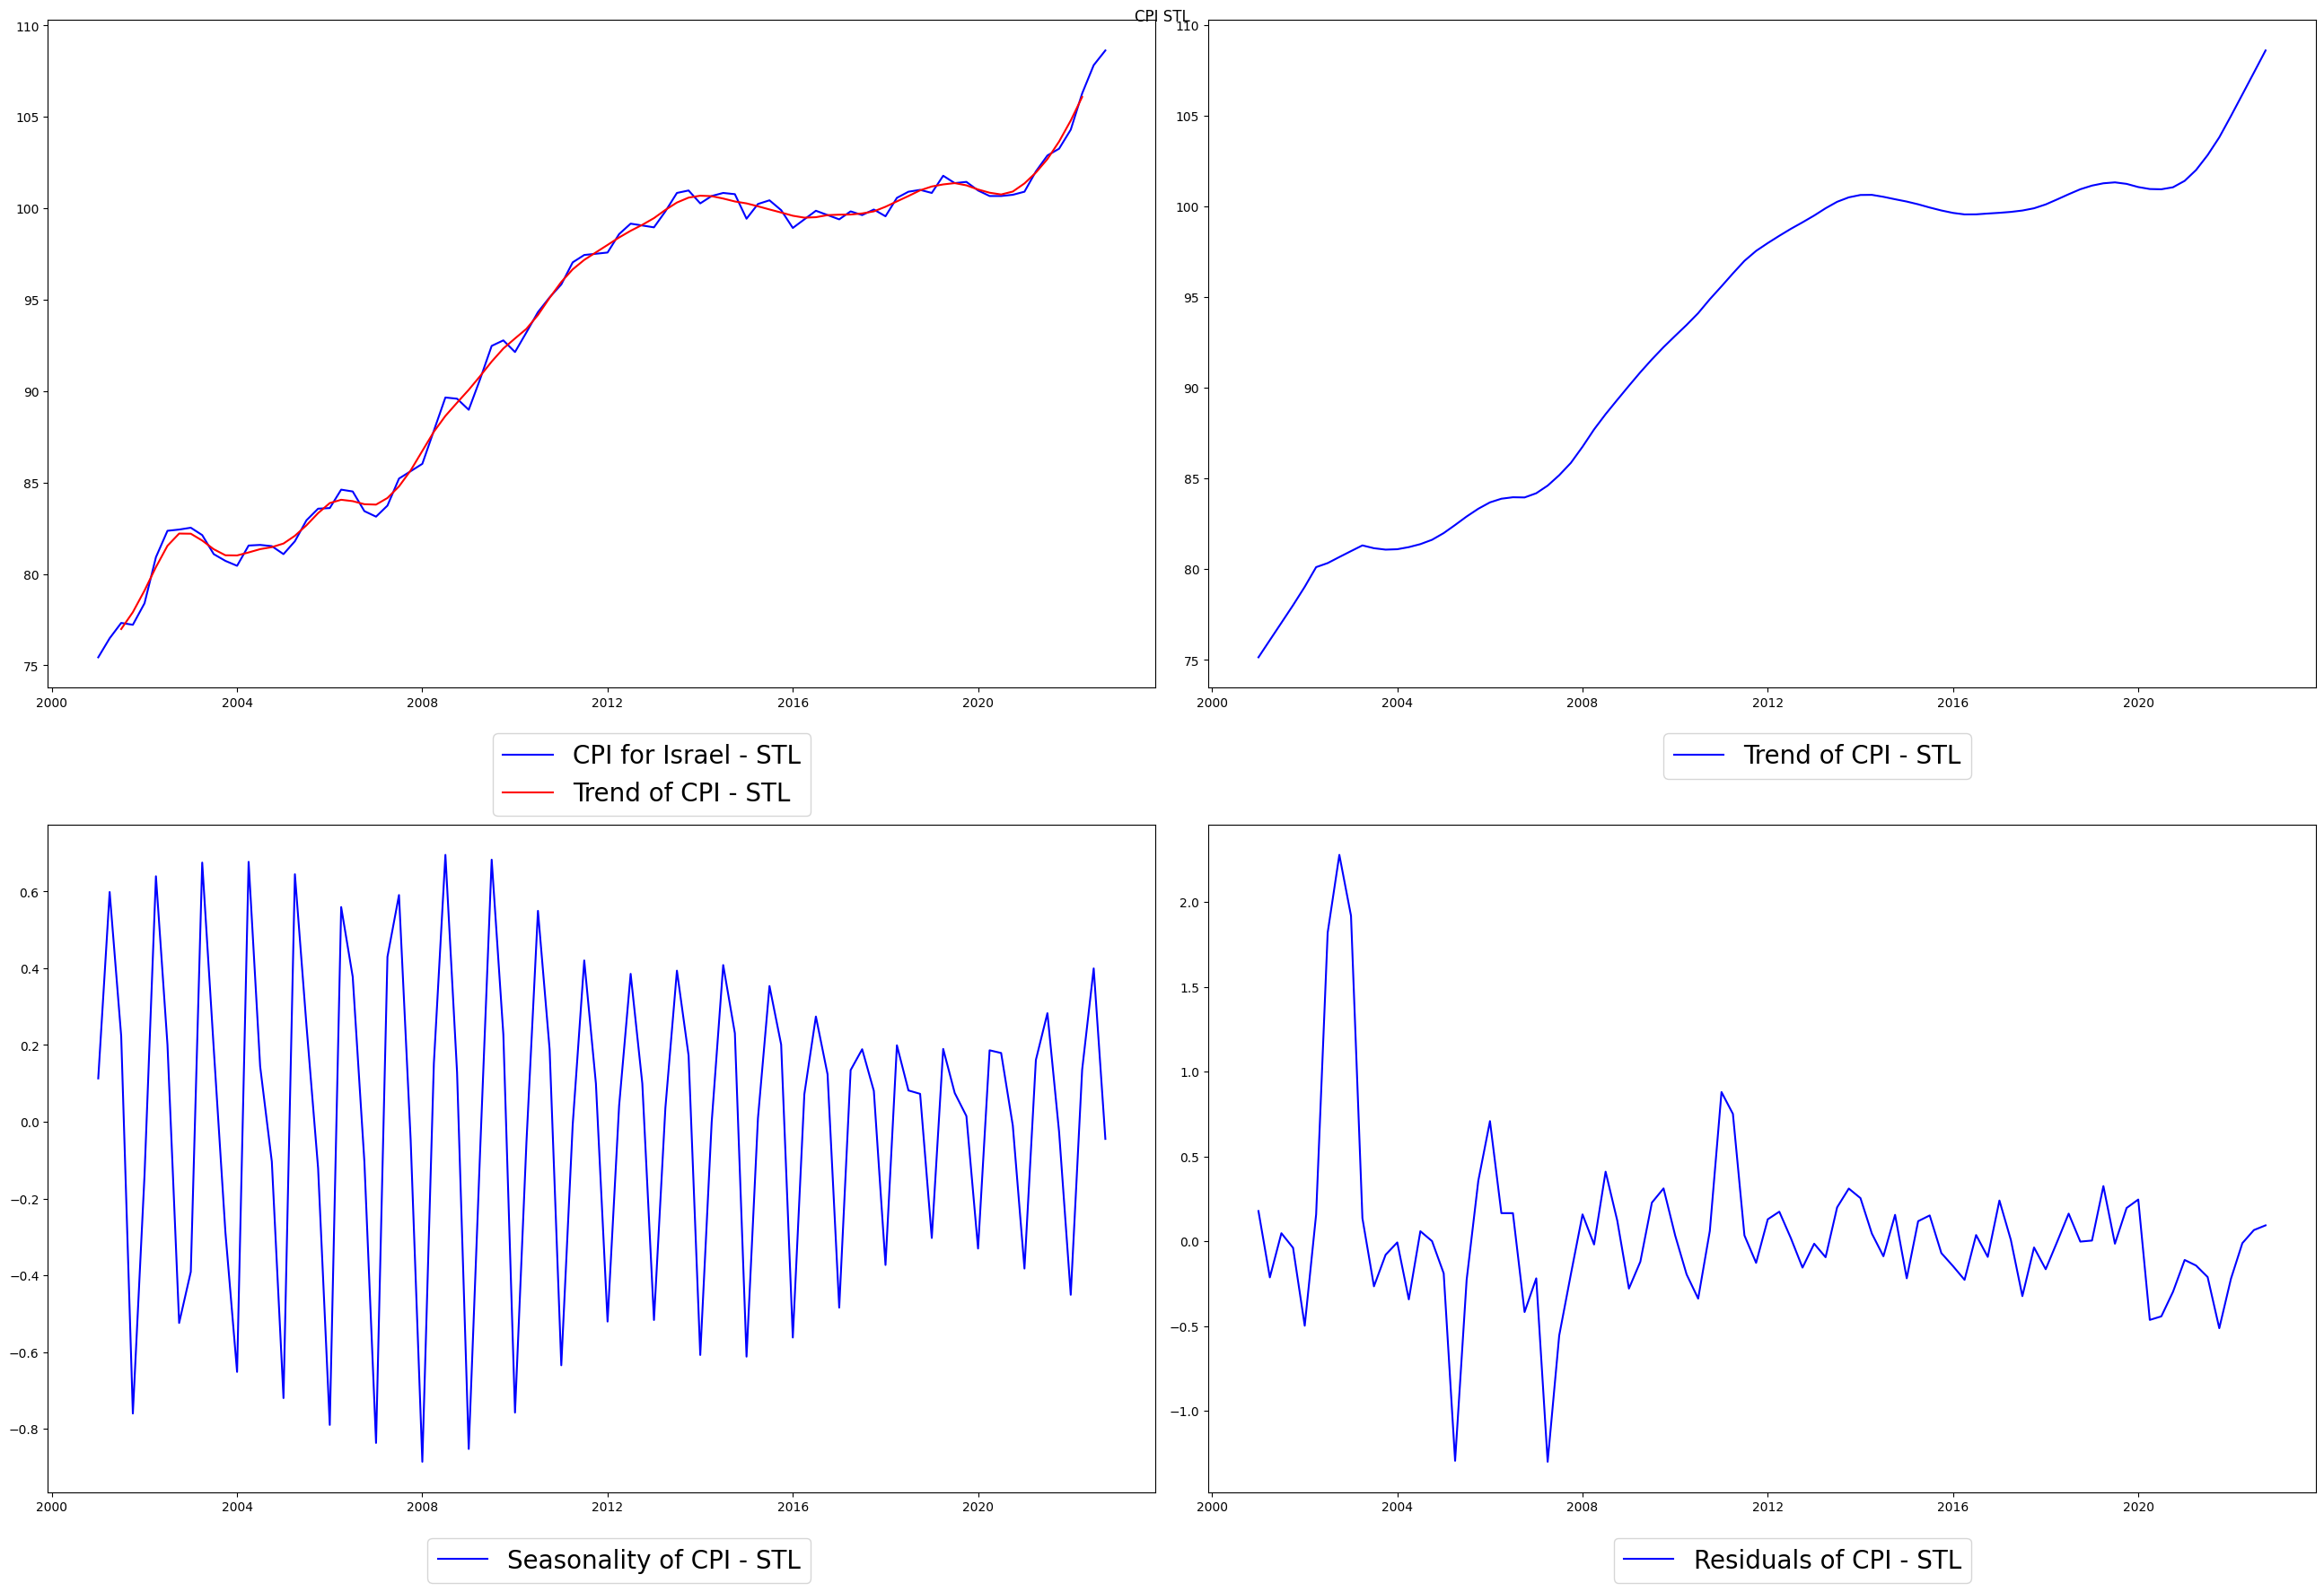

In [9]:
# decompose with STL
cpi_stl = STL(y, robust=True).fit()

plt.rcParams["figure.figsize"] = (26,18)
plt.suptitle('CPI STL', )
plt.subplot(221)
plt.plot(cpi_stl.observed ,label='CPI for Israel - STL', color='blue')
plt.plot(trend_estimate ,label='Trend of CPI - STL' , color='red')
plt.legend(loc='best',fontsize=20 , bbox_to_anchor=(0.70, -0.05))
plt.subplot(222)
plt.plot(cpi_stl.trend ,label='Trend of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(223)
plt.plot(cpi_stl.seasonal ,label='Seasonality of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.subplot(224)
plt.plot(cpi_stl.resid ,label='Residuals of CPI - STL',color='blue')
plt.legend(loc='best',fontsize=20, bbox_to_anchor=(0.70, -0.05))
plt.tight_layout()
plt.show()

#### Comments:
As can be seen on the seasonality plot, STL allows for different patterns of seasonality to be expressed, growing and reducing in size along the x axis. The variability of the seasonality, nevertheless, is still low. The trend plot is very similar to the one obtained with the additive decomposition. Since this method is able to more percisely seperate the seasonal pattern from the trend, the effect of de-seasoning the series might not be as strong as before, resulting in non-stationary residuals. A formal test of the underlying models can be viewed below.

In [10]:
# check stationarity for residuals
y_resid = cpi_stl.resid.dropna()
print("\n-------------------------------------------------")
print("Augmented Dickey-Fuller (ADF) test")
print("    H0: unit root (variable is NOT stationary)")
print("    H0: no unit root (variable is stationary)")
print("---------------------------------------------------")

print("ADF test for residuals - various underlying models:")
res = tsa.adfuller(y_resid, regression='c',autolag='AIC')
print("    (1) ADF p-value (const):",res[1])
res = tsa.adfuller(y_resid, regression='ct',autolag='AIC')
print("    (2) ADF p-value (const + trend):",res[1])
res = tsa.adfuller(y_resid, regression='ctt',autolag='AIC')
print("    (3) ADF p-value (const + trend + quad trend):",res[1])
res = tsa.adfuller(y_resid, regression='n',autolag='AIC')
print("    (4) ADF p-value (no const + no trend):",res[1])


-------------------------------------------------
Augmented Dickey-Fuller (ADF) test
    H0: unit root (variable is NOT stationary)
    H0: no unit root (variable is stationary)
---------------------------------------------------
ADF test for residuals - various underlying models:
    (1) ADF p-value (const): 0.00031876519857332867
    (2) ADF p-value (const + trend): 0.00038209689433912165
    (3) ADF p-value (const + trend + quad trend): 0.06112834179042951
    (4) ADF p-value (no const + no trend): 1.8437192586137755e-05


#### Comments:
The formal tests with a constant, constant and trend and no constant and no trend all suggest that the residuals are now stationary at α = 0.01 significance level. On the other hand, the test for constant, trend and quadratic trend (yt = α + βt + γt2 + εt) suggests that the series is still not stationary at α = 0.05. This underlying model looks for a trend stationarity, which suggests that the residuals still have a trend after decompositioning.


STATIONARITY ANALYSIS FOR: De-seasoned Series with STL

------------------------------- (1) Time series plot -------------------------------


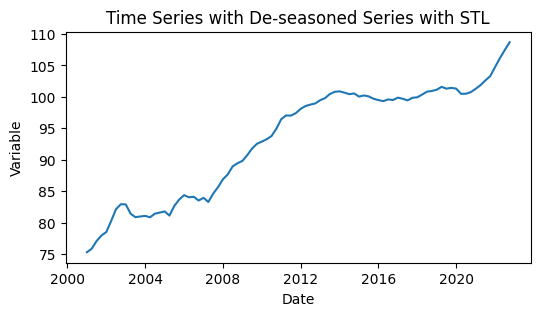

------------------------------- (2) ACF and PACF plot -------------------------------


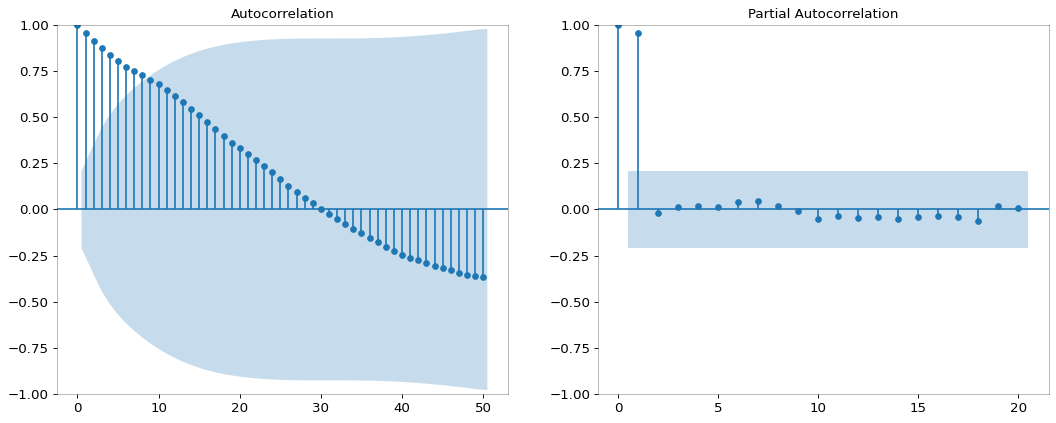

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 0.8986765940643631
    (2) ADF p-value (const + trend): 0.5375936044443081
    (3) ADF p-value (const + trend + quad trend): 0.8192736952118423
    (4) ADF p-value (no const + no trend): 0.988996503578044


In [11]:
# plot time series, autocorrelation and partial-autocorrelation functions of deseasoned series
y_deseasoned = y - cpi_stl.seasonal
title = 'De-seasoned Series with STL'
common.Stationarity_analysis(y_deseasoned, title)


#### Comments:
By removing the seasonal component alone, the autocorrelation function shows a very strong trend, decaying slowly and continuing to grow in an almost linear pattern. The first partial autocorrelation is very high, with all subsequent partial autocorrelations insignificant. Accorfing to the ADF test, the de-seasoned series cannot be considered stationary for all underlying models. These results are in line with the initial analysis showing that the variability of the seasonal component is low and it cannot account for most of the non-stationarity in the time series.

Since the series appears to have a stochastic trend and the seasonal component is very small, a difference of the time series will be taken to transform the series into a stationary one.


STATIONARITY ANALYSIS FOR: 2nd Difference of the Series

------------------------------- (1) Time series plot -------------------------------


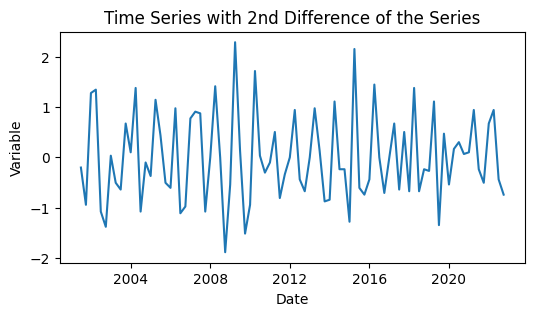

------------------------------- (2) ACF and PACF plot -------------------------------


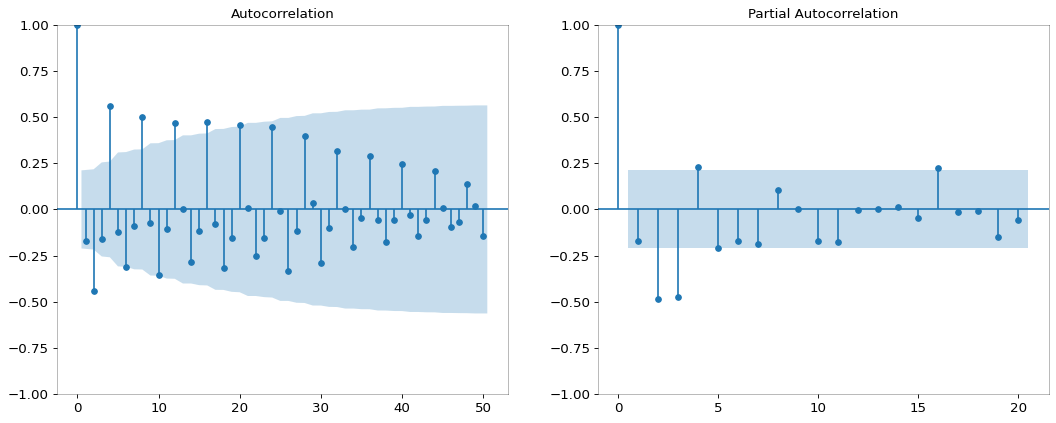

------------------------------- (3) ADF test -------------------------------
ADF test - various underlying models:
    (1) ADF p-value (const): 1.1522185954180465e-06
    (2) ADF p-value (const + trend): 6.794068306827363e-06
    (3) ADF p-value (const + trend + quad trend): 3.433729400069134e-05
    (4) ADF p-value (no const + no trend): 4.884777665096971e-08


In [10]:
# plot time series, autocorrelation and partial-autocorrelation functions of the de-seasoned and differenced series
title = '2nd Difference of the Series'
common.Stationarity_analysis(ddy, title)



#### Comments:
Following the assumption that the CPI time series is difference stationary integrated of 2nd order, it appears that the transformation indeed results in stationarity. By taking the 2nd difference, the residuals are now stationary according to the ADF tests for all underlying models. Meanwhile, the ACF plot shows that autocorrelation is decaying with each lag, while PACF is significant up to the 3rd lag. Therefore, this transformation will be assessed onwards by potential ARMA models up to p=4 and q=3.

In [11]:
for i,j in [(1, 1), (2, 1), (3, 1), (4, 1), (1, 2), (2, 2), (3, 2), (4, 2), (1, 3), (2, 3), (3, 3), (4, 3)]:
    model = ARIMA(ddy, order=(i, 0, j))
    model_results = model.fit()
    print(f'Summary of the Estimated ARMA ({i}, {j}) Model :')
    print(model_results.summary())

    # test for heteroskedasticity
    common.test_het(model_results)

    # test normality of errors
    common.test_norm(model_results)

    # test serial correlation with Ljung-Box Q and Ljung-Box Q*
    common.serial_corr(model_results, 12)

    common.serial_corr_all_lags(model_results, 12)


Summary of the Estimated ARMA (1, 1) Model :
                               SARIMAX Results                                
Dep. Variable:                 amount   No. Observations:                   86
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -94.668
Date:                Tue, 23 May 2023   AIC                            197.336
Time:                        20:31:35   BIC                            207.154
Sample:                    07-01-2001   HQIC                           201.287
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.007     -0.296      0.767      -0.015       0.011
ar.L1          0.3492      0.104      3.367      0.001       0.146       0.553
ma.L1  

# Ljung-Box Q* test and Box-Pierce Test
#### In order to check for serial correlation of lags up to largest lag: 
*"If lags is a list or array, then all lags are included up to the largest lag in the list, however only the tests for the lags in the list are reported."*

#### From https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html



In [66]:
# Ljung-Box Q* test
sm.stats.acorr_ljungbox(model_results.resid, lags=[12], return_df=True, model_df=4, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,8.870429,0.353344,7.989313,0.434515


### Description
#### Ljung-Box: 

<img align="right" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/df44d87dccf7b56d16ceae7c44880053de9ff3a7"
     alt="Ljung-Box Formula"
     style="clear: both; margin-right: 10px; background-color: white;" />

* A portmanteau test, where:
    * H0: the data is independently distributed (for all lags up to tested lag jointly).
    * H1: the data exhibits some serial correlation.
* The results  are compared to a  χ2 distribution with h degrees of freedom (where h is the number of lags being tested)
* When used to test the model residuals, the degrees of freedom are deducted the number of estimated parameters in the ARMA model (p and q)
* It can be described as a weighted sum of squared autocorrelations at lags 1 through h
* A significant result (a result with p-value smaller than a given alpha) indicate a significant autocorrelation in the data for the given lags

#### Box-Pierce:

<img align="right" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cf757b9bfb96d2980b0536f9758aeb49ae06a631"
     alt="Box-Pierce Formula"
     style="clear: both; margin-right: 10px; background-color: white;" />

* Similarly to Ljung-Box, it is a portmanteau test, where:
    * H0: the data is independently distributed (for all lags up to tested lag jointly).
    * H1: the data exhibits some serial correlation.
* It is similar to the Ljung-Box test in certain features:
    * Q statistic with m degrees of freedom (minus the number of estimated parameters for ARMA model)
    * The results are compared to a  χ2. When testing the residuals of an ARMA model, the distribution has h-p-q degrees of freedom.
* It differs from the Ljung-Box test (which was developed to answer the deficiency in Box-Pierce), by the fact that it is shown to considerably deviate from a χ2 distribution for all sample sizes, including moderate and small smaples.
    * The imperfection of the Box-Pierce test raises the risk of commiting a type 1 error (Ray and Xiaolou)
    * To resolve this, a weighted term is added to the Ljung-Box test (and subsequent models which attempted to prevent the test's over-correction, e.g. Fisher, 2011 or Monti, 1994)

